In [3]:
import ROOT as rt
import sys
import collections
from collections import OrderedDict
import uproot
import pandas as pd
import numpy as np

import scipy
import awkward
import time
import subprocess

GIT_REPO = subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')
sys.path.append(GIT_REPO + '/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import L1_trg, deltaPhi

from scipy.stats import norm
import math
import CMS_lumi, tdrstyle
style = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0


print(sys.version)

Welcome to JupyROOT 6.24/06
3.6.8 (default, Nov  2 2021, 13:01:57) 
[GCC 8.4.1 20200928 (Red Hat 8.4.1-1)]


# Load ntuples

In [4]:
%%time

fpath =OrderedDict()
tree = OrderedDict()

start_t = time.time()

for data_year in ['all']:

    if data_year == 'all':path = f'/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19//Data_all/v14/normalized/'
    else: path = f'/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19//Data{data_year}/v14/normalized/'
    if data_year == '2022':fpath['data'+data_year] = path + "DisplacedJet-EXOCSCCluster_Run2022-PromptReco_goodLumi.root"
    elif data_year == '2023':fpath['data'+data_year] = path + "Muon-EXOCSCCluster_Run2023-PromptReco_goodLumi.root"
    elif data_year == 'all':fpath['data'+data_year] = path + "EXOCSCCluster_Run2022_2023_goodLumi.root"

fpath['sig'] = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19/MC_all/v14/normalized/ggH_Hto2Sto4B_MH-125-MS-15-ctauS-1000_TuneCP5_13p6TeV_powheg-pythia8_50000pb_weighted.root'
NEvents = {}

for k,v in fpath.items():
    print (k, v)
    root_dir = uproot.open(v) 

    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'].values()[0]
    # NEvents[k] = root_dir['NEvents'].counts()
    print("NEvents",NEvents[k])


dataall /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19//Data_all/v14/normalized/EXOCSCCluster_Run2022_2023_goodLumi.root
NEvents 34804216.0
sig /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19/MC_all/v14/normalized/ggH_Hto2Sto4B_MH-125-MS-15-ctauS-1000_TuneCP5_13p6TeV_powheg-pythia8_50000pb_weighted.root
NEvents 57555044.0
CPU times: user 391 ms, sys: 21.7 ms, total: 412 ms
Wall time: 653 ms


# apply selections

In [7]:
%%time

cscRechitClusterPhi = {}
cscRechitClusterSize = {}
dtRechitClusterPhi = {}
deltaPhi_cluster  = {}
cscRechitClusterDNN  = {}
dtRechitClusterSize  = {}
dtRechitClusterEta = {}
cscRechitClusterEta = {}
cscRechitClusterNStation = {}
dtRechitClusterNStation = {}
dtRechitClusterBX  = {}
deltaR_cluster = {}
deltaEta_cluster = {}
HMTEff = {}
weight = {}
categories = ['lowMET','highMET']
categories = ['lowMET']
region_list = ['invertDNN', 'oot', 'signal']
for region in region_list:
    for tree_k in tree.keys():
        T = tree[tree_k]
        
        for met_cat in categories:
            # if not (met_cat == 'highMET'):continue
            k = f'{region}_{tree_k}_{met_cat}'
            ########### SELECTION: CLUSTERS ############
            me1 = (T['cscRechitClusterNRechitChamberPlus11'].array()+ T['cscRechitClusterNRechitChamberPlus12'].array()+\
            T['cscRechitClusterNRechitChamberMinus11'].array()+ T['cscRechitClusterNRechitChamberMinus12'].array())

            #one cluster to pass trigger
            csccluster = np.logical_and(T['cscRechitClusterTimeWeighted'].array() < 12.5, T['cscRechitClusterTimeWeighted'].array() > -5)
            csccluster = csccluster & (me1 ==0)
            csccluster = csccluster & (T['cscRechitClusterTimeSpreadWeightedAll'].array()<20)
            csccluster = csccluster & (T['cscRechitClusterSize'].array()>160)
            csccluster = csccluster & (T['cscRechitClusterJetVetoPt'].array()<30)
            csccluster = csccluster & np.logical_not((T['cscRechitClusterMuonVetoPt'].array() > 30) & T['cscRechitClusterMuonVetoGlobal'].array())    


            dtcluster = (T['dtRechitClusterNHitStation1'].array()==0)
            dtcluster = dtcluster & (T['dtRechitCluster_match_RPChits_dPhi0p5'].array() >= 1)
            dtcluster = dtcluster & (T['dtRechitClusterJetVetoPt'].array()<30)
            dtcluster = dtcluster & np.logical_not((T['dtRechitClusterMuonVetoPt'].array() > 30) & T['dtRechitClusterMuonVetoLooseId'].array())


        ########### SELECTION: EVENTS ############
            sel_ev = T['HLT_CSCDT'].array()
            sel_ev = sel_ev & (T['nCscRechitClusters'].array()==1) & (T['nDtRechitClusters'].array()==1)
            
            if met_cat == 'lowMET':
                sel_ev = np.logical_and(sel_ev ,T['met'].array() < 200)
                
                
            sel_ev  = sel_ev & (np.sum(dtcluster, axis = 1) == 1)
            sel_ev  = sel_ev & (np.sum(csccluster, axis = 1) == 1)
            print(k, np.count_nonzero(sel_ev))
        ########### BRANCHES ############

           ##### event variables ##### 
            # make sure cluster0 and cluster1 index are different

            cscRechitClusterPhi[k] = T['cscRechitClusterPhi'].array()[csccluster][sel_ev][:,0]
            dtRechitClusterPhi[k] = T['dtRechitClusterPhi'].array()[dtcluster][sel_ev][:,0]
            deltaPhi_cluster[k] = deltaPhi(np.array(cscRechitClusterPhi[k]), np.array(dtRechitClusterPhi[k]))

            cscRechitClusterDNN[k] = T['cscRechitClusterDNN_bkgMC_plusBeamHalo'].array()[csccluster][sel_ev][:,0]
            dtRechitClusterBX[k] = T['dtRechitCluster_match_RPCBx_dPhi0p5'].array()[dtcluster][sel_ev][:,0]
            dtRechitClusterSize[k] = T['dtRechitClusterSize'].array()[dtcluster][sel_ev][:,0]

            sel = (np.abs(deltaPhi_cluster[k])>0.4)
            
            if 'oot' in region:sel = sel & (cscRechitClusterDNN[k] > 0.96) & (dtRechitClusterBX[k]<0)
            elif 'invertDNN' in region: sel = sel & (cscRechitClusterDNN[k] < 0.96) & (dtRechitClusterBX[k] == 0)
            elif 'signal' in region:sel = sel & (cscRechitClusterDNN[k] > 0.96) & (dtRechitClusterBX[k] == 0)
            else: assert(False)


            print(k, np.count_nonzero(sel))
            cscRechitClusterSize[k] = T['cscRechitClusterSize'].array()[csccluster][sel_ev][sel][:,0]
            cscRechitClusterEta[k] = T['cscRechitClusterEta'].array()[csccluster][sel_ev][sel][:,0]
            dtRechitClusterEta[k] = T['dtRechitClusterEta'].array()[dtcluster][sel_ev][sel][:,0]
            cscRechitClusterNStation[k] = T['cscRechitClusterNStation10'].array()[csccluster][sel_ev][sel][:,0]
            dtRechitClusterNStation[k] = T['dtRechitClusterNStation10'].array()[dtcluster][sel_ev][sel][:,0]
            cscRechitClusterDNN[k] = T['cscRechitClusterDNN_bkgMC_plusBeamHalo'].array()[csccluster][sel_ev][sel][:,0]

            deltaPhi_cluster[k] = deltaPhi_cluster[k][sel]
            
            deltaR_cluster[k] = ((cscRechitClusterEta[k]-dtRechitClusterEta[k])**2 + deltaPhi_cluster[k]**2)**0.5
            deltaEta_cluster[k] = cscRechitClusterEta[k]-dtRechitClusterEta[k]
            dtRechitClusterSize[k] = dtRechitClusterSize[k][sel]
            HMTEff[k] = T['cscRechitClusterHMTEfficiency'].array()[sel_ev][sel][:,0]
            weight[k] = (T['pileupWeight'].array()*T['weight'].array())[sel_ev][sel]*HMTEff[k]
            if 'data' in k:weight[k] = T['weight'].array()[sel_ev][sel]*0.0 + 1
            print(k,len(weight[k]),np.sum(weight[k]))
            if np.count_nonzero(sel)<=1:continue
            print("correlation between two variables:", k, scipy.stats.pearsonr(deltaPhi_cluster[k], dtRechitClusterSize[k]))
            print("events in this region:", k, len(deltaPhi_cluster[k]))

invertDNN_dataall_lowMET 4920
invertDNN_dataall_lowMET 330
invertDNN_dataall_lowMET 330 330.0
correlation between two variables: invertDNN_dataall_lowMET (0.04139281612026884, 0.4536126187302014)
events in this region: invertDNN_dataall_lowMET 330
invertDNN_sig_lowMET 2726
invertDNN_sig_lowMET 235
invertDNN_sig_lowMET 235 206.12671
correlation between two variables: invertDNN_sig_lowMET (-0.05963163814901457, 0.3627848047078807)
events in this region: invertDNN_sig_lowMET 235
oot_dataall_lowMET 4920
oot_dataall_lowMET 263
oot_dataall_lowMET 263 263.0
correlation between two variables: oot_dataall_lowMET (-0.030389325519642966, 0.6237108881910916)
events in this region: oot_dataall_lowMET 263
oot_sig_lowMET 2726
oot_sig_lowMET 8
oot_sig_lowMET 8 4.7132792
correlation between two variables: oot_sig_lowMET (0.5914799668530774, 0.12248797238263352)
events in this region: oot_sig_lowMET 8
signal_dataall_lowMET 4920
signal_dataall_lowMET 363
signal_dataall_lowMET 363 363.0
correlation betwee

# Plot 1D distributions

invertDNN_dataall_lowMET 0.0
invertDNN_dataall_lowMET 0.9999999999999999 330
oot_dataall_lowMET 1.0
oot_dataall_lowMET 1.0 263
signal_sig_lowMET 1.0
signal_sig_lowMET 0.9999999999999999 2390
0.07138299942016602


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/deltaR_cluster_dtcsc.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/deltaR_cluster_dtcsc.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/deltaR_cluster_dtcsc.C has been generated


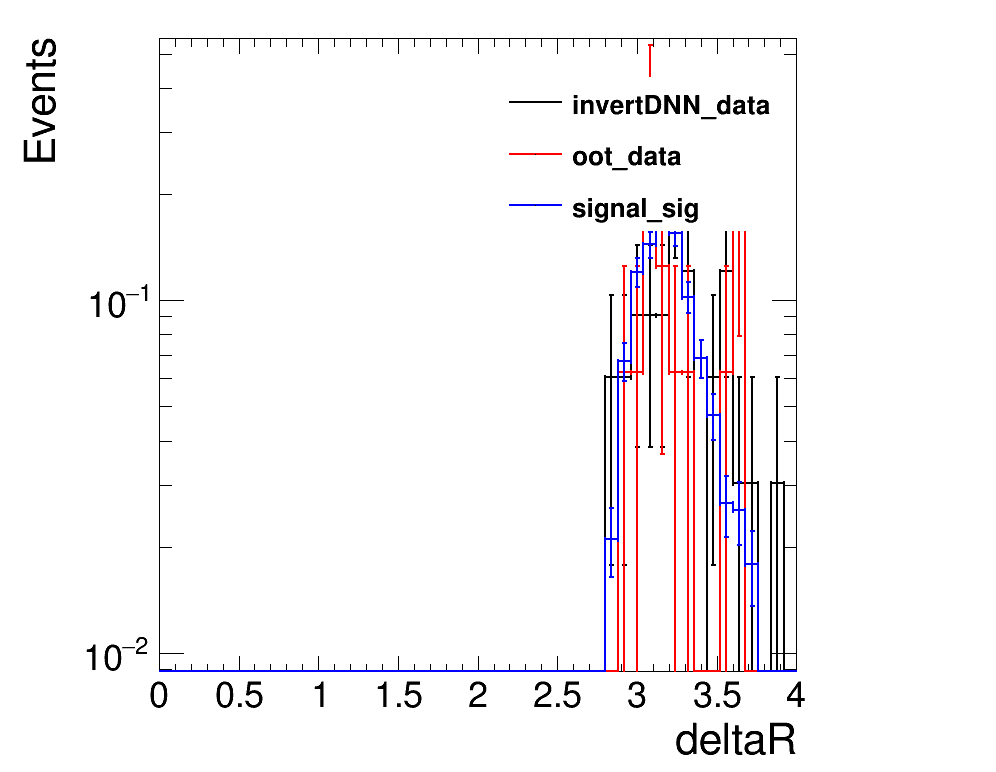

In [8]:
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
leg = rt.TLegend(0.5,0.7,0.8,0.9)
leg.SetBorderSize(0)
plot_var = [dtRechitClusterSize, deltaPhi_cluster, cscRechitClusterEta,cscRechitClusterSize,cscRechitClusterNStation, dtRechitClusterNStation, cscRechitClusterDNN, deltaR_cluster]
axis = ['N_{dt rechits}','#Delta#phi','csc cluster #eta','N_{csc rechits}', 'csc cluster N_{station 10}', 'dt cluster N_{station 10}', 'cscRechitClusterDNN','deltaR']
name = ['nhits','dphi','cscRechitClusterEta','cscRechitClusterSize','cscRechitClusterNStation10', 'dtRechitClusterNStation10', 'cscRechitClusterDNN','deltaR_cluster',]
bins = [[25,50,500],[25,1.8,3.2],[50,1,2.5],[50,0,800],[5,0,5], [5,0,5], [50,0.5,1], [50,0,4]]

plot_index = 7
i = 0
for k in plot_var[plot_index].keys():

    if 'signal_dataall' in k:continue
    if 'invertDNN_sig_lowMET' in k or 'oot_sig_lowMET' in k:continue
    cond = cscRechitClusterSize[k]>160
    cond = cond & (np.abs(deltaPhi_cluster[k])>2.8)
    h[k] = create_TH1D( np.abs(np.array(plot_var[plot_index][k][cond])), axis_title = [axis[plot_index],'Events'], binning=bins[plot_index], weights = np.array(weight[k][cond]))
    print(k, np.sum(weight[k][cscRechitClusterDNN[k]>0.96])/np.sum(weight[k]))

    
    if h[k].Integral()>0:h[k].Scale(1./h[k].Integral())
    h[k].SetLineColor(std_color_list[i])
    leg.AddEntry(h[k],k.replace('all','').replace('_lowMET',''))
    h[k].Draw('hist E1 same')
    i+=1

    print(k, h[k].Integral(), len(dtRechitClusterSize[k]))
    
leg.Draw()
if plot_index == 0 or plot_index == 3:c.SetLogy()
c.SetRightMargin(0.2)
c.SetLogy()
c.Draw()

c.SaveAs(GIT_REPO + "/plots/ABCD/"+name[plot_index]+"_dtcsc.png")
c.SaveAs(GIT_REPO + "/plots/ABCD/"+name[plot_index]+"_dtcsc.pdf")
c.SaveAs(GIT_REPO + "/plots/ABCD/"+name[plot_index]+"_dtcsc.C")


print(time.time()-start_t)

# 2D distribution of dphi and Nrechits

invertDNN_dataall_lowMET 133.0 330
invertDNN_sig_lowMET 212.0 235
oot_dataall_lowMET 143.0 263
oot_sig_lowMET 8.0 8
signal_dataall_lowMET 91.0 363
signal_sig_lowMET 2107.0 2390
0.3549060821533203


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/dtcsc_invertDNN_dataall_lowMET.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/dtcsc_invertDNN_dataall_lowMET.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/dtcsc_invertDNN_dataall_lowMET.C has been generated
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/dtcsc_invertDNN_sig_lowMET.png has been created
Info in <TCanvas::Print>: pdf file /storage/a

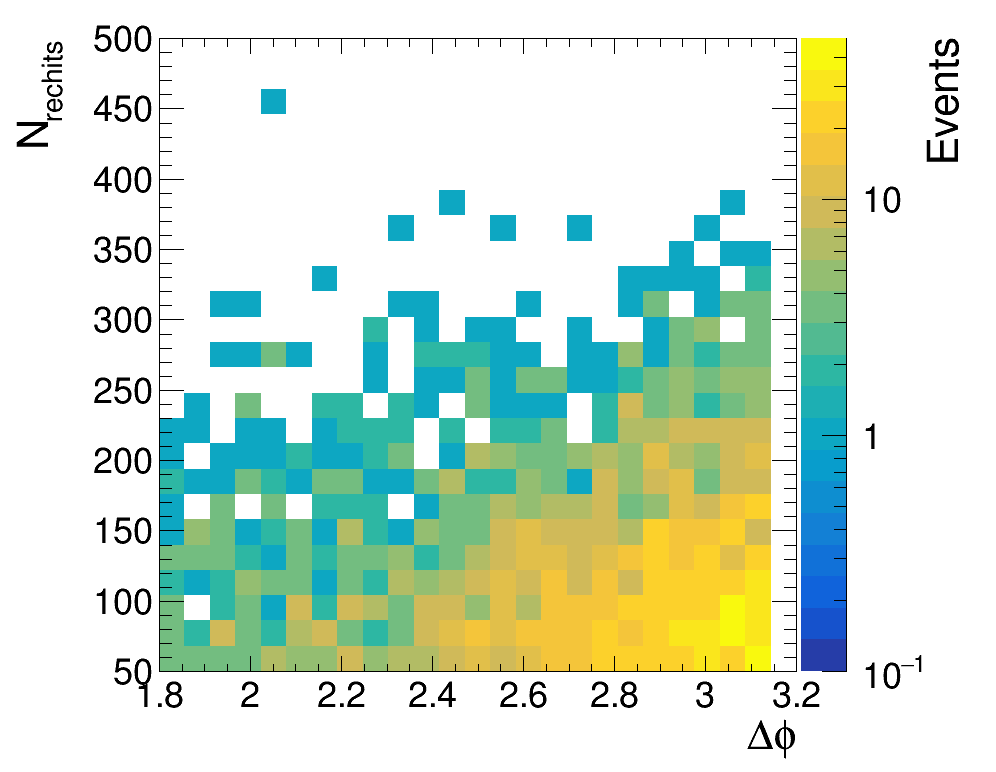

In [9]:
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)

for k in dtRechitClusterSize.keys():
    
    h = create_TH2D(np.column_stack(( np.abs(deltaPhi_cluster[k]), np.array(dtRechitClusterSize[k]), )),
                   axis_title = ['#Delta#phi','N_{rechits}','Events'], binning=[25,1.8,3.2,25,50,500,])

    h.SetMinimum(0.1)
    h.Draw('colz')
    c.SetRightMargin(0.2)

    print(k, h.Integral(), len(dtRechitClusterSize[k]))
    # if setlog: 
    c.SetLogz()
    c.Draw()

    c.SaveAs(GIT_REPO + "/plots/ABCD/dtcsc_"+k+".png")
    c.SaveAs(GIT_REPO + "/plots/ABCD/dtcsc_"+k+".pdf")
    c.SaveAs(GIT_REPO + "/plots/ABCD/dtcsc_"+k+".C")
    



print(time.time()-start_t)

# ABCD (Scan Nrechits)

In [10]:
a = {}
b = {}
c = {}
d = {}
cuts = np.arange(50,106,1)
cuts = np.arange(60,300,10)
# cuts = np.arange(90,150,1)
n_ev = 5000

table = {}
latex_table = {}

# cuts = [90,95,100,104,105]
print(cuts)
bkg_dphiJet = []
sig_dphiJet = []
bkg_dphiCluster = []
sig_dphiCluster = []
print_jetmet = 0
DPHI_CUT = 2.8

for k in dtRechitClusterSize.keys():
    if 'sig' in k:continue
    print("*****************************")
    print(f"******** {k} **********")
    print("*****************************")
    table[k] = {
        # "dPhi cuts": ['dphi', 'A', 'B', 'C', 'D', 'prediction', 'uncertainty'],
        "Nhits cuts":[],
        "A": [],
        "B": [],
        "C": [],
        "D": [],
        "pred":[],
        "uncertainty":[],
    }
    
    for N_RECHIT_CUT in cuts:
        if N_RECHIT_CUT<80:continue
        var = np.abs(deltaPhi_cluster[k])
        
        a[k] = np.count_nonzero([np.logical_and(dtRechitClusterSize[k]>=N_RECHIT_CUT, var>=DPHI_CUT)])
        b[k] = np.count_nonzero([np.logical_and(dtRechitClusterSize[k]>=N_RECHIT_CUT, var<DPHI_CUT)])
        c[k] = np.count_nonzero([np.logical_and(dtRechitClusterSize[k]<N_RECHIT_CUT, var<DPHI_CUT)])
        d[k] = np.count_nonzero([np.logical_and(dtRechitClusterSize[k]<N_RECHIT_CUT, var>=DPHI_CUT)])


        if b[k] == 0 or c[k] == 0 or d[k] ==0:break
        pred = b[k]*d[k]/c[k]
        unc_pred = (1./c[k] + 1./b[k] + 1./d[k])**0.5*pred
        if math.isnan(unc_pred): z_value = float("nan")
        else:
            mu = np.random.normal(pred, unc_pred, n_ev)
            p_value = 0.0
            for i in mu:
                if i < 0:continue
                n = np.random.poisson(i, n_ev)
                p_value += np.count_nonzero(n>=a[k])

            p_value = p_value/n_ev**2
            z_value = abs(norm.ppf(p_value))
        print(N_RECHIT_CUT, '\t',a[k],'\t',b[k],'\t',c[k],'\t',d[k],'\t', round(pred, 2), '\t',\
              round( unc_pred, 2), '\t', round(z_value,2))
        
        
        table[k]['Nhits cuts'].append(DPHI_CUT)
        table[k]['A'].append(a[k])
        table[k]['B'].append(b[k])
        table[k]['C'].append(c[k])
        table[k]['D'].append(d[k])
        table[k]['pred'].append(pred)
        table[k]['uncertainty'].append(unc_pred)
        
        
        
    table[k] = pd.DataFrame(table[k])
    latex_table[k] = table[k].to_latex(
    index=False,  # To not include the DataFrame index as a column in the table
    column_format="|l|l|l|l|l|",  # The format of the columns: left-aligned with vertical lines between them
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
    float_format="{:0.2f}".format  # Formats floats to two decimal places
    )

    print(latex_table[k])


[ 60  70  80  90 100 110 120 130 140 150 160 170 180 190 200 210 220 230
 240 250 260 270 280 290]
*****************************
******** invertDNN_dataall_lowMET **********
*****************************
80 	 6 	 80 	 216 	 28 	 10.37 	 2.38 	 1.26
90 	 4 	 54 	 242 	 30 	 6.69 	 1.58 	 1.07
100 	 4 	 42 	 254 	 30 	 4.96 	 1.23 	 0.51
110 	 3 	 30 	 266 	 31 	 3.5 	 0.92 	 0.38
120 	 2 	 20 	 276 	 32 	 2.32 	 0.68 	 0.36
130 	 2 	 15 	 281 	 32 	 1.71 	 0.54 	 0.02
140 	 2 	 13 	 283 	 32 	 1.47 	 0.49 	 0.2
150 	 0 	 12 	 284 	 34 	 1.44 	 0.49 	 2.88
160 	 0 	 11 	 285 	 34 	 1.31 	 0.46 	 2.73
170 	 0 	 9 	 287 	 34 	 1.07 	 0.4 	 2.6
180 	 0 	 8 	 288 	 34 	 0.94 	 0.38 	 2.43
190 	 0 	 5 	 291 	 34 	 0.58 	 0.28 	 2.04
200 	 0 	 5 	 291 	 34 	 0.58 	 0.28 	 2.07
210 	 0 	 5 	 291 	 34 	 0.58 	 0.28 	 2.02
220 	 0 	 5 	 291 	 34 	 0.58 	 0.28 	 2.05
230 	 0 	 4 	 292 	 34 	 0.47 	 0.25 	 1.9
240 	 0 	 4 	 292 	 34 	 0.47 	 0.25 	 1.92
250 	 0 	 3 	 293 	 34 	 0.35 	 0.21 	 1.59
2

# ABCD (Scan dPhi)

In [11]:

a = {}
b = {}
c = {}
d = {}
cuts = np.arange(50,106,1)
cuts = np.arange(0,35,2)/10
cuts = np.arange(1.8,3.2,0.05)
print(cuts)
n_ev = 1000


table = {}
latex_table = {}

N_RECHIT_CUT = 90
for k in dtRechitClusterSize.keys():
    if 'sig' in k:continue
    
    table[k] = {
        # "dPhi cuts": ['dphi', 'A', 'B', 'C', 'D', 'prediction', 'uncertainty'],
        "dPhi cuts":[],
        "A": [],
        "B": [],
        "C": [],
        "D": [],
        "pred":[],
        "uncertainty":[],
    }
    print("*****************************")
    print(f"******** {k} **********")
    print("*****************************")
    for DPHI_CUT in cuts:
        var = np.abs(deltaPhi_cluster[k])
        
        a[k] = np.count_nonzero([np.logical_and(dtRechitClusterSize[k]>=N_RECHIT_CUT, var>=DPHI_CUT)])
        b[k] = np.count_nonzero([np.logical_and(dtRechitClusterSize[k]>=N_RECHIT_CUT, var<DPHI_CUT)])
        c[k] = np.count_nonzero([np.logical_and(dtRechitClusterSize[k]<N_RECHIT_CUT, var<DPHI_CUT)])
        d[k] = np.count_nonzero([np.logical_and(dtRechitClusterSize[k]<N_RECHIT_CUT, var>=DPHI_CUT)])


        if b[k] == 0 or c[k] == 0 or d[k] ==0:continue
        pred = b[k]*d[k]/c[k]
        unc_pred = (1./c[k] + 1./b[k] + 1./d[k])**0.5*pred
        if math.isnan(unc_pred): z_value = float("nan")
        else:
            mu = np.random.normal(pred, unc_pred, n_ev)
            p_value = 0.0
            for i in mu:
                if i < 0:continue
                n = np.random.poisson(i, n_ev)
                p_value += np.count_nonzero(n>=a[k])

            p_value = p_value/n_ev**2
            z_value = abs(norm.ppf(p_value))
        print(round(DPHI_CUT,2), '\t',a[k],'\t',b[k],'\t',c[k],'\t',d[k],'\t', round(pred, 2), '\t',\
              round( unc_pred, 2), '\t', round(z_value,2))
        # table[k][DPHI_CUT] = [DPHI_CUT, int(a[k]),b[k],c[k],d[k],pred,unc_pred]

        
        table[k]['dPhi cuts'].append(DPHI_CUT)
        table[k]['A'].append(a[k])
        table[k]['B'].append(b[k])
        table[k]['C'].append(c[k])
        table[k]['D'].append(d[k])
        table[k]['pred'].append(pred)
        table[k]['uncertainty'].append(unc_pred)
        
        
        
    table[k] = pd.DataFrame(table[k])
    latex_table[k] = table[k].to_latex(
    index=False,  # To not include the DataFrame index as a column in the table
    column_format="|l|l|l|l|l|",  # The format of the columns: left-aligned with vertical lines between them
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
    float_format="{:0.2f}".format  # Formats floats to two decimal places
    )

    print(latex_table[k])


[1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45
 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.   3.05 3.1  3.15]
*****************************
******** invertDNN_dataall_lowMET **********
*****************************
1.8 	 19 	 39 	 158 	 114 	 28.14 	 5.68 	 1.25
1.85 	 18 	 40 	 160 	 112 	 28.0 	 5.61 	 1.36
1.9 	 17 	 41 	 164 	 108 	 27.0 	 5.38 	 1.5
1.95 	 17 	 41 	 171 	 101 	 24.22 	 4.85 	 1.2
2.0 	 16 	 42 	 174 	 98 	 23.66 	 4.72 	 1.23
2.05 	 15 	 43 	 178 	 94 	 22.71 	 4.51 	 1.28
2.1 	 14 	 44 	 183 	 89 	 21.4 	 4.25 	 1.32
2.15 	 13 	 45 	 189 	 83 	 19.76 	 3.93 	 1.27
2.2 	 12 	 46 	 192 	 80 	 19.17 	 3.81 	 1.36
2.25 	 12 	 46 	 196 	 76 	 17.84 	 3.57 	 1.18
2.3 	 12 	 46 	 200 	 72 	 16.56 	 3.34 	 0.94
2.35 	 11 	 47 	 208 	 64 	 14.46 	 2.95 	 0.8
2.4 	 10 	 48 	 213 	 59 	 13.3 	 2.74 	 0.85
2.45 	 9 	 49 	 216 	 56 	 12.7 	 2.63 	 0.97
2.5 	 8 	 50 	 220 	 52 	 11.82 	 2.47 	 1.05
2.55 	 7 	 51 	 225 	 47 	 10.65 	 2.27 	 1.05